In [8]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

# Data preprocessing 
transform_train = transforms.Compose([
    # Padding the image by 4 pixels on each side,
    # then take a random crop of size 32x32 pixels. 
    transforms.RandomCrop(32, padding=4),
    # Randomly flip the image horizontally with a probability of 0.5
    transforms.RandomHorizontalFlip(),
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    # Normalize the image
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),
    # Normalize the image
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load datasets, I use CIFAR10 here
trainset = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        # Convolutional and BatchNorm layers defined here
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        # If the input number of channels is different from the output,
        # then the shortcut needs to adjust the dimensions
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        # Forward pass logic including shortcut connections
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module): # ResNet-18
    def __init__(self, block, num_blocks, num_classes=10):
        # Layers are set up here including intial conv
        super(ResNet, self).__init__()
        self.in_planes = 64
        # Initial the first convolutional layer, 
        # 3 input channels for RGB, 64 output channels, kernel size 7x7, stride 2, padding 3
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        # BatchNorm and ReLU layers are added
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        # Maxpool layer is added 
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # 4 blocks are created using the _make_layer helper function
        self.layers = nn.Sequential(
            self._make_layer(block, 64, num_blocks[0], stride=1),
            self._make_layer(block, 128, num_blocks[1], stride=2),
            self._make_layer(block, 256, num_blocks[2], stride=2),
            self._make_layer(block, 512, num_blocks[3], stride=2)
        )
        # AdaptiveAvgPool layer is added
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # Final linear layer is added
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        # Helper function to create a block of layers
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.maxpool(out)
        out = self.layers(out)
        out = self.avgpool(out)
        # Reshape the output to fit the linear layer input
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


# ResNet18: 4 layers of BasicBlock, 2 blocks per layer, 2 conv layers per block
net = ResNet(BasicBlock, [2, 2, 2, 2])


In [10]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (layers): Sequential(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

In [11]:
import torch
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

# CrossEntropyLoss and SGD optimizer are used
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [12]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [13]:
def train(epoch):
    # Training logic including forward pass, loss calculation, and backpropagation 
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_losses.append(train_loss / len(trainloader))
    train_accuracies.append(100. * correct / total)

def test(epoch):
    # Evaluation logic including forward pass and accuracy calculation
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    test_losses.append(test_loss / len(testloader))
    test_accuracies.append(100. * correct / total)


epoch: 0
           train accuracy: 48.97 train loss: 1.40
           test accuracy: 55.50 test loss: 1.35

epoch: 1
           train accuracy: 67.77 train loss: 0.91
           test accuracy: 69.16 test loss: 0.90

epoch: 2
           train accuracy: 75.25 train loss: 0.70
           test accuracy: 75.39 test loss: 0.74

epoch: 3
           train accuracy: 79.09 train loss: 0.60
           test accuracy: 76.88 test loss: 0.69

epoch: 4
           train accuracy: 81.84 train loss: 0.52
           test accuracy: 79.62 test loss: 0.62

epoch: 5
           train accuracy: 83.80 train loss: 0.47
           test accuracy: 82.84 test loss: 0.51

epoch: 6
           train accuracy: 85.35 train loss: 0.42
           test accuracy: 83.56 test loss: 0.50

epoch: 7
           train accuracy: 86.43 train loss: 0.39
           test accuracy: 85.08 test loss: 0.45

epoch: 8
           train accuracy: 87.34 train loss: 0.36
           test accuracy: 83.09 test loss: 0.52

epoch: 9
           train ac

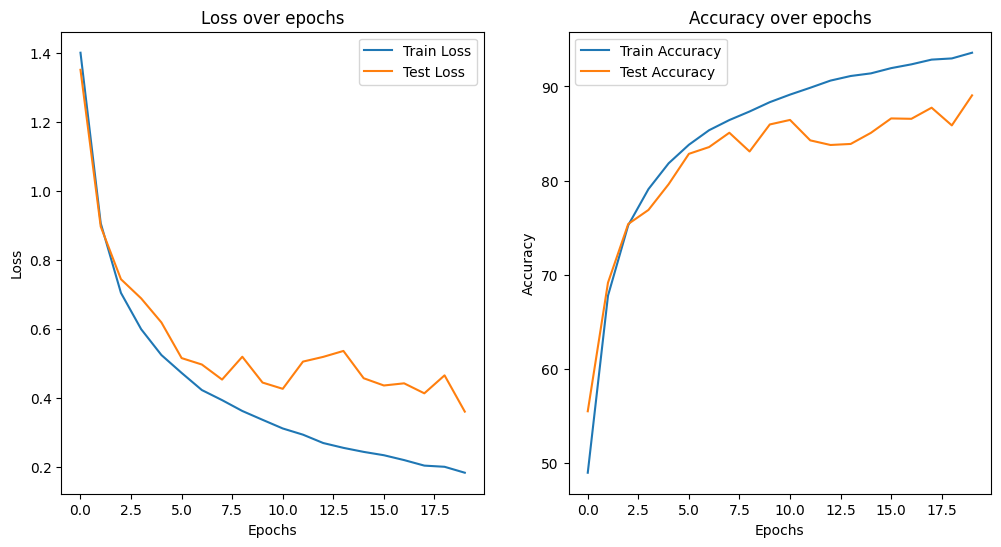

In [14]:
from tqdm import trange

for epoch in range(20):
    train(epoch)
    test(epoch)
    print(f"epoch: {epoch}\n \
          train accuracy: {train_accuracies[-1]:.2f} train loss: {train_losses[-1]:.2f}\n \
          test accuracy: {test_accuracies[-1]:.2f} test loss: {test_losses[-1]:.2f}\n")

# Plotting code to visualize training and testing loss and accuracy 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()